# Regression Analysis - Waze navigation app

The goal of this notebook is to build a **binomial logistic regression model** and evaluate the model's performance.

1. EDA & Checking model assumptions
2. Model building and Evaluation
3. Interpreting model results


## 1. EDA & Checking model assumptions

### Imports and data loading

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
df = pd.read_csv('waze_dataset.csv')

### Exploratory Data Analysis

#### Summary information

In [ ]:
print(df.shape)
print()
df.head(10)
df.info()
print()
df.describe()

(14999, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB



,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


**Conclusion:** <br>
- The 'label' column is missing 700 values.
- The 'ID' column does not contain important information for the analysis (can be removed)
- The following columns have max values that are multiple standard deviations above the 75th percentile. This could indicate outliers:
  - 'sessions'
  - 'drives'
  - 'total_sessions'
  - 'total_navigations_fav1'
  - 'total_navigations_fav2'
  - 'driven_km_drives'
  - 'duration_minutes_drives'



#### Data cleaning

In [ ]:
# Drop rows with missing data
df = df.dropna(subset=['label'])

# Drop 'ID' column
df = df.drop('ID', axis=1)

#Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

#### Create features

##### **'km_per_driving_day'**

We know from earlier EDA in Notebook:"..." that churn rate correlates with distance driven per driving day in the last month. It might be helpful to engineer a feature that captures this information

In [ ]:
# Create 'km_per_driving_day' column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Check summary info's on the new column
df['km_per_driving_day'].describe()

,km_per_driving_day
count,1.429900e+04
mean,inf
std,NaN
min,3.022063e+00
25%,1.675616e+02
50%,3.237524e+02
75%,7.415597e+02
max,inf


Some values are infinite. This is the result of there being values of zero in the 'driving_days' column. This happens because division by zero is undefined.

To solve the problem we convert these values from infinity to zero.

In [ ]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

,km_per_driving_day
count,14299.000000
mean,567.010426
std,970.136935
min,0.000000
25%,136.168003
50%,273.301012
75%,543.473676
max,8898.716275


##### **'professional_driver'**

We create a binary feature that is a 1 for users who had 60 or more drives and drove on 15+ days in the last month.

In [ ]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

# Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver
0    11811
1     2488
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

**Conclusion:** <br>
The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

## 2. Model builing and Evaluation

### Encode categorical variables


We change the data type of the 'label' column to be binary. This change is needed to train a **logistic regression model**.

We assign a **'0'** for all **'retained'** users and a **'1'** for all **'churned'** users.

In [ ]:
# Create new binary 'label2' variable
df['label_binary'] = np.where(df['label']=='churned', 1, 0)

df[['label', 'label_binary']].tail()

,label,label_binary
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


Create dummies

In [ ]:
# Create new binary 'device2' variable
df['device_binary'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device_binary']].tail()

,device,device_binary
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


### Collinearity

In a logisitc regression model collinearitiy (correlation between independent variables) can cause overfitting and unreliable predictions.

We check the data for collinearity by using a **correlation matrix**.

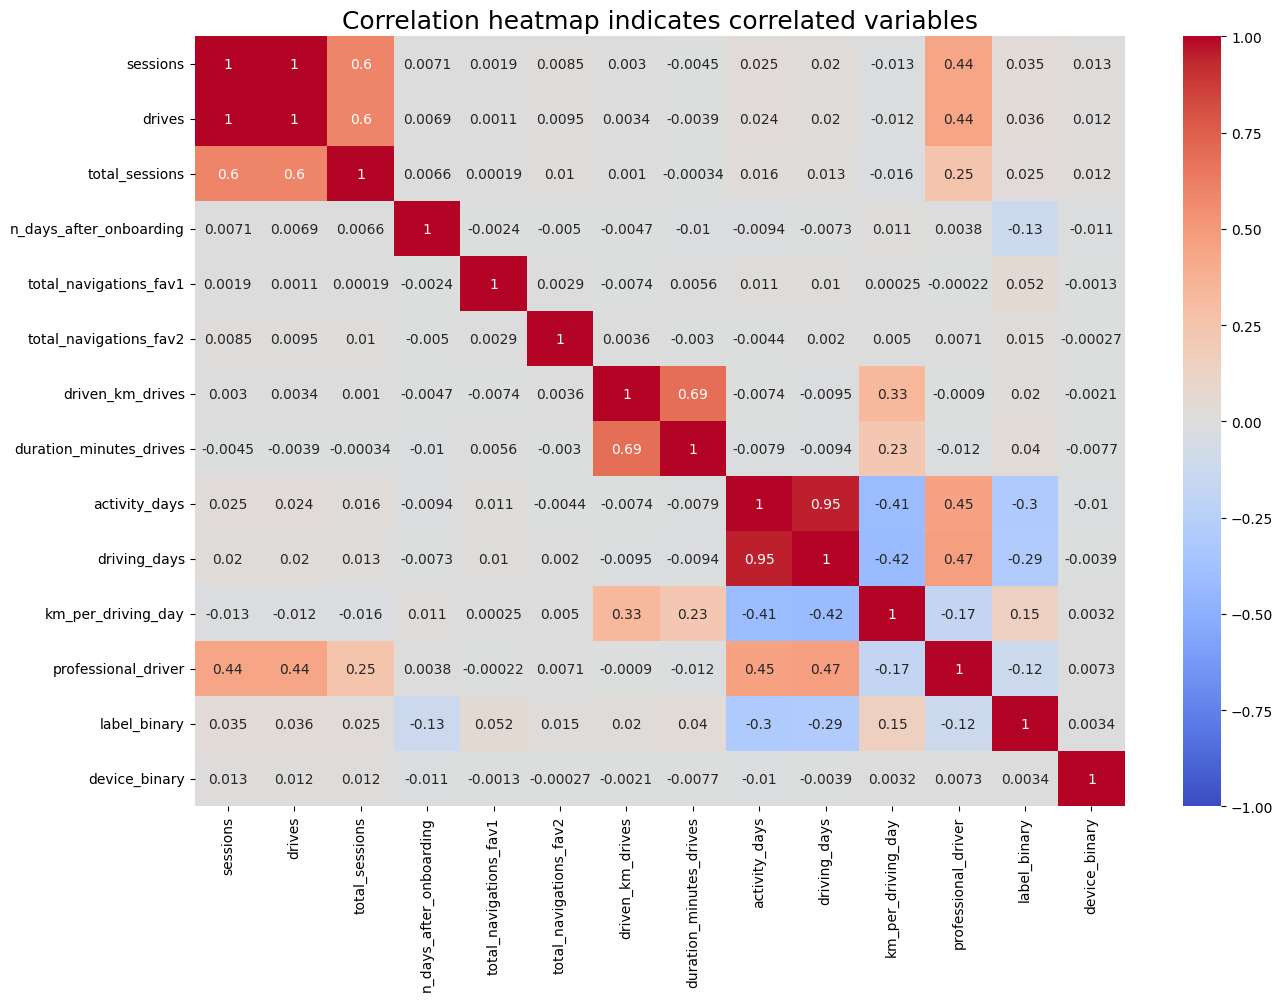

In [ ]:
# filter numeric data
df_numeric = df.select_dtypes(include=['number'])

# Generate a correlation matrix
corr_matrix = df_numeric.corr(method='pearson')

# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df_numeric.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

plt.title('Correlation heatmap indicates correlated variables', fontsize=18)
plt.show();

**Conclusion:** <br>
There are two pairs of variables that are strongly multicollinear with each other:
- **'sessions' & 'drives'**: correlation value = 1
- **'driving_days' & 'activity_days'**: correlation value = 0.95

As we know, the **target variable** for the model is **'label_binary'**. We choose to drop 'sessions' and 'driving_days' and keep 'drives' and 'activity_days' for modeling. <br>
The reason for this is that the features we keep for modeling have stronger correlations with the target variable than the features we drop.

### Build a model

#### Predictor and Target variables

First, we drop all variables we don't use for modeling. <br>
The remaining variables are the **predictor variables 'X'**. <br>

In [ ]:
# Predictor variables
X = df.drop(columns = ['label', 'label_binary', 'device', 'sessions', 'driving_days'])

# Target variable
y = df['label_binary']

#### Train/Test split

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

 #### Create model

In [ ]:
model = LogisticRegression(penalty=None, max_iter=400) # 'penalty = None' for unscaled predictors

# fit the model with training data
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, penalty=None)

#### Evaluation

##### Coefficients

represent the change in log odds of the targer variable for one unit increase in X

In [ ]:
pd.Series(model.coef_[0], index=X.columns)

,0
drives,0.001936
total_sessions,0.000356
n_days_after_onboarding,-0.000401
total_navigations_fav1,0.001251
total_navigations_fav2,0.000990
driven_km_drives,-0.000012
duration_minutes_drives,0.000110
activity_days,-0.105526
km_per_driving_day,0.000016
professional_driver,-0.007098


##### Intercept value

represents the baseline log-odds when all feature values are zero, indicating the model's bias

In [ ]:
model.intercept_


array([-0.05401771])

##### Training probabilities

In [ ]:
# Get the predicted probabilities of the training data in 2D-array
training_probabilities = model.predict_proba(X_train)

training_probabilities

array([[0.93734917, 0.06265083],
       [0.62314221, 0.37685779],
       [0.76608587, 0.23391413],
       ...,
       [0.91798063, 0.08201937],
       [0.84861162, 0.15138838],
       [0.93332342, 0.06667658]])

##### Log-odds

In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. <br>
Here is the formula for calculating log-odds, where p is the probability of response: <br>
**𝑙𝑜𝑔𝑖𝑡(𝑝)=𝑙𝑛(𝑝/1−𝑝)**

In [ ]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

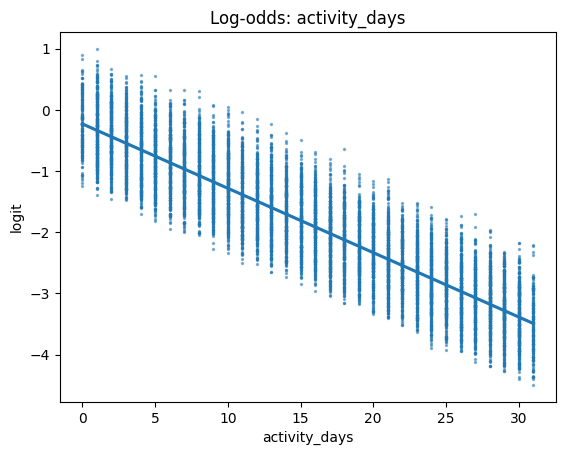

In [ ]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

##### Classification report

In [ ]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.15       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



##### Confusion matrix

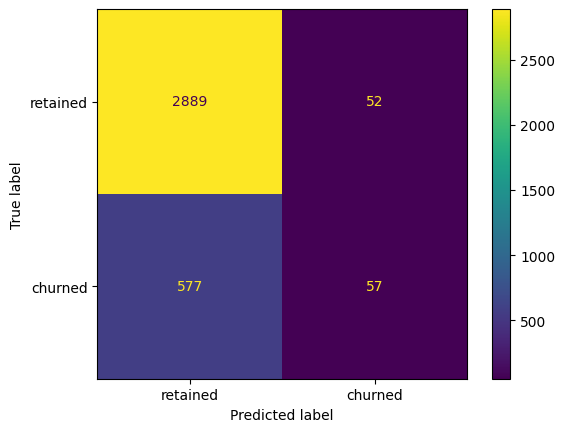

In [ ]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_preds)

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot();

### 3. Interpreting model results

- The model has **mediocre precision and very low recall**, which means that it makes a **lot of false negative predictions** and **fails to capture users who will churn**

- 'activity_days' is by far the **most important feature** in the model. It has negative correlation with user churn. This is not surprising, as this variable is very strongly correlated with 'driving_days', which is known from previous EDA to have a negative correlation to churn.

- In previous EDA, user churn rate increased as the values in 'km_per_driving_day' increased. The correlation heatmap here in this notebook revealed this variable to have the** strongest positive correlation with churn of any of the predictor variables** by a relatively large margin. In the model, it is the second-least-important variable.

- The model used is not a strong enough predictor, as made clear by its **poor recall score**.

- To improve the model, new features could be engineered to try to generate better predictive signal. In the case of this model, one of the engineered features ('professional_driver') is the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features.

- **Additional information like drive-level information for each user** (such as drive times, geographic locations, etc.) would help to improve the model. It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs.

